### Please use this notebook inside google colab environment. In Runtime select "Run All", and after the execution, it will show the perplexity result of MVAE-BM in 20 NewsGroups Dataset.

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf 
import numpy as np
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='15rpusOs1XALBuAVLZPUs2OepenxqZSsF',
                                    dest_path='./20news.zip',
                                    unzip=True)

TensorFlow 1.x selected.


In [ ]:
#@title Load 20NewsGroups
voc = open("20news/vocab.new",'r')

ds = {}
#dic_r = {}
for i,x in enumerate(voc):
    #print (i,x)
    word = x.split(' 0')[0]
    ds[str(i)] = word
    #dic_r[word] = i
train = open("20news/train.feat",'r')
t = []
text = []

for x in train:
    a = x.split(' ')
    aux = ''
    
    for y in range(1,len(a)):
        try :
            r = str(int(a[y].split(':')[0])-1)
            r2 = a[y].split(':')[1]
            aux+=(int(r2)*(ds[r]+' '))
            flag = 1
        except:
            # line break
            flag = 0
    if flag == 1:
        text.append(aux)

test = open("20news/test.feat",'r')
t = []
text_test = []

for x in test:

    a = x.split(' ')
    aux = ''
    
    for y in range(1,len(a)):

        try :
            r = str(int(a[y].split(':')[0])-1)
            r2 = a[y].split(':')[1]
            aux+=(int(r2)*(ds[r]+' '))
            flag = 1
        except:
            # line break
            flag = 0

    if flag == 1:
        text_test.append(aux)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid,= train_test_split(text, test_size=0.10 ,random_state=42)

In [ ]:
#@title Bag of Words Encode
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from random import shuffle

vectorizer = CountVectorizer()

trainX = vectorizer.fit_transform(X_train)
validX = vectorizer.transform(X_valid)
testX = vectorizer.transform(text_test)

voc = vectorizer.vocabulary_


indices = np.arange(trainX.shape[0]) #gets the number of rows 
shuffle(indices)


print('train shape:',trainX.shape,"test shape:",testX.shape)

train shape: (10132, 1994) test shape: (7487, 1994)


In [ ]:
cluster = 1 #size of c
h_len = 50 #size of h
batch_size = 32
c_s = 1000
epochs = 400
eta = 0.00023

In [ ]:
#@title MVAE-BM model Build
ep = 1e-20
temp = 0.1


x = tf.placeholder(tf.float32, shape=[None,trainX.shape[1]])
batch = tf.placeholder(tf.int32, shape=())


def encoder_h(x,name="classDecoder"):

        W1 = tf.Variable(tf.random.uniform([trainX.shape[1],1000],0.05,-0.05),name='W1',dtype=tf.float32)
        b1 = tf.Variable(tf.zeros([1000]),name='bias1',dtype=tf.float32)

        layer1 = tf.nn.sigmoid(tf.matmul(x,W1) + b1)

        W2 = tf.Variable(tf.random.uniform([1000,750],0.05,-0.05),name='W2')
        b2 = tf.Variable(tf.zeros([750]),name='bias2',dtype=tf.float32)

        layer2 = tf.nn.sigmoid(tf.matmul(layer1,W2) + b2)

        W3 = tf.Variable(tf.random.uniform([750,h_len],-0.05,0.05),name='WMu')
        b3 = tf.Variable(tf.zeros([h_len]),name='biasMu',dtype=tf.float32)

        W4 = tf.Variable(tf.random.uniform([750,h_len],0,0),name='WSigma')
        b4 = tf.Variable(tf.zeros([h_len]),name='biasSigma',dtype=tf.float32)

        mu = tf.matmul(layer2,W3) + b3
        log_sigma = tf.matmul(layer2,W4) + b4

        return mu,log_sigma

def encoder_c(hs,name="C"):

    with tf.variable_scope(name):
    
        W1 = tf.Variable(tf.random.uniform([trainX.shape[1],1000],-0.05,0.05),name='W1')
        b1 = tf.Variable(tf.zeros([1000]),name='bias1',dtype=tf.float32)

        
        layer1 = tf.nn.tanh(tf.matmul(hs,W1) + b1)

        W2 = tf.Variable(tf.random.uniform([1000,cluster],-0.05,0.05),name='W2')
        b2 = tf.Variable(tf.zeros([cluster]),name='bias2',dtype=tf.float32)

        layer2 = tf.nn.tanh(tf.matmul(layer1,W2) + b2)
        return layer2


def decoder(x,h,name='ClassEncoder'):

     with tf.variable_scope(name):

          R = tf.Variable(tf.random.uniform([h_len,trainX.shape[1]],-0.05,0.05),name='RWord')
          b = tf.Variable(tf.zeros([trainX.shape[1]]),name='biasWord')

          h_R = tf.nn.log_softmax(tf.matmul(h,R)+b)

          un_probs = tf.reduce_sum(tf.multiply(h_R,x),axis=1)

          return un_probs,R,h_R


#h
eps = tf.random_normal((batch,h_len), 0,1)
mu,log_sigma = encoder_h(x)
h = mu+tf.multiply(tf.exp(log_sigma),eps)

#c 
eps2 = tf.random_uniform((batch,cluster), 0,1)
eps2 = -tf.log(-tf.log(eps2+ep))
C = encoder_c(x)
C2 = C+eps2
C2 = tf.nn.softmax(C2/temp,axis=1)


# Doing mixture 
logits = []
word_embedding = []
topic = []

for l in range(0,int(cluster)):

    un_probs,R,h_R = decoder(x,h,name="Class_"+str(l))
    
    logits.append(un_probs)
    word_embedding.append(R)
    topic.append(h_R)

decoder_probs = tf.multiply(logits,tf.transpose(C2))
decoder_probs = tf.reduce_sum(decoder_probs,axis=0)

# Calcule ELBO

kld_c = tf.reduce_sum(tf.nn.softmax(C,axis=1)*tf.log(tf.nn.softmax(C,axis=1)/(1.0/np.float(cluster))),axis=1)
kld_h = -0.5 * tf.reduce_sum(1 - tf.square(mu) + 2 * log_sigma - tf.exp(2 * log_sigma), 1) 

ELBO = decoder_probs - kld_c - kld_h
mean_ELBO = -tf.reduce_mean(ELBO)

optimizer = tf.train.AdamOptimizer(learning_rate=eta)

step = optimizer.minimize(mean_ELBO)

sess = tf.Session()
print('Initializing...')

init = tf.global_variables_initializer()
sess.run(init)


Initializing...


In [ ]:
#@title Train MVAE-BM
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

out = display(progress(0, 100), display_id=True)
    


keep_elbo_ppr = []

for ll in range(0,epochs):

    begin = 0
    end = batch_size

    while end <=trainX.shape[0]:

        select = indices[begin:end]

        feed_dict = {x:trainX[select].toarray().reshape(batch_size,trainX.shape[1]),batch:batch_size}
        sess.run(step,feed_dict=feed_dict)

        begin = end
        end += batch_size
            
    #print ("### EPOCH",ll," #####")
    out.update(progress(ll, epochs))
    feed_dict = {x:validX.toarray(),batch:validX.shape[0]}
    elbo = sess.run(ELBO,feed_dict=feed_dict)
    
    # clean memory, importat for large dataset
    feed_dict = {}
    del feed_dict
    feed_dict = 2

    val_matrix = validX.toarray()
    ppr  = np.exp(-np.sum(elbo/np.sum(val_matrix,axis=1))/np.float(validX.shape[0]))
    #print(np.mean(elbo),ppr)
    keep_elbo_ppr.append([np.mean(elbo),ppr])

    # clean memory, importat for large dataset
    del ppr
    del val_matrix

    val_matrix = 0
    ppr = 0

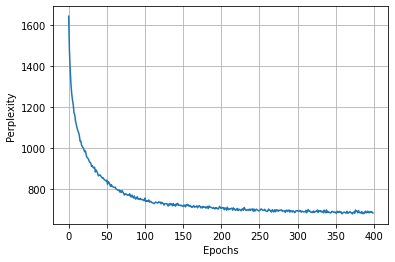

In [ ]:
import matplotlib.pyplot as plt
keep_elbo_ppr = np.array(keep_elbo_ppr)
plt.grid()
plt.plot(keep_elbo_ppr[:,1])
plt.ylabel('Perplexity ')
plt.xlabel('Epochs');

In [ ]:
feed_dict = {x:testX.toarray(),batch:testX.shape[0]}
elbo = sess.run(ELBO,feed_dict=feed_dict)
val_matrix2 = testX.toarray()
ppr  = np.exp(-np.sum(elbo/np.sum(val_matrix2,axis=1))/np.float(testX.shape[0]))
print(ppr)

714.9961561871557
